In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

2023-01-19 09:34:24.467743: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


In [2]:
MEMORY = 23*1024

gpus = tf.config.list_physical_devices('GPU')
try:
    tf.config.set_logical_device_configuration(gpus[0],
                                              [tf.config.LogicalDeviceConfiguration(memory_limit=MEMORY)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
except RuntimeError as e:        
    # Memory growth must be set before GPUs have been initialized
    print(e)    

1 Physical GPUs, 1 Logical GPUs


2023-01-19 09:34:39.713119: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2023-01-19 09:34:39.757278: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:2d:00.0 name: Quadro RTX 6000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2023-01-19 09:34:39.757325: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2023-01-19 09:34:39.759763: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2023-01-19 09:34:39.762085: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10
2023-01-19 09:34:39.762458: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcurand.so.10
2

In [3]:
sys.path.append("/end/home/rh2310/morpho_repo/turing_codebase")
from turing.utils import *
from turing.tf_utils import *
import turing.pinns as tu
from turing.loss_functions import *

In [4]:
sim = "Koch_Meinhardt_7"
data_path = os.path.abspath(f"../../test/outputs_Koch_Meinhardt_100_by_100/{sim}/{sim}.npy")
with open(data_path, 'rb') as f:
    data = np.load(f)

data_path = os.path.abspath(f"../../test/outputs_Koch_Meinhardt_100_by_100/{sim}/simulation.txt")
with open(data_path, 'r') as f:
    simulation = eval(f.read())

In [5]:
data.shape

(2, 100, 100, 1537)

In [6]:
simulation

Simulation(name='Koch_Meinhardt_7', n=(100, 100), L=(24, 24), Ds=(0.1, 1.0), dt=0.001, t_start=0, t_end=1536.0, t_steps=1537, dt_arr=None, parameters={'kappa_u': 1.0, 'mu_u': 0.1, 'rho_u': 0.04, 'rho_v': 1.5, 'sigma_u': 0.0, 'sigma_v': 1.0}, steady_state_func=None, perturbation_size=0.1, kinetic_func=None, tol=0.001, sample_parameters=True, sample_parameters_num=10, sample_parameters_std=(0.0, 0.001, 0.0004, 0.01, 0.0, 0.01), same_init=True, c0=None)

In [7]:
t_star = np.linspace(simulation.t_start, 
                     simulation.t_end, 
                     simulation.t_steps)

T = t_star.shape[0]    

L = simulation.L[0]
x_size = data.shape[1]
y_size = data.shape[2]
N = x_size*y_size

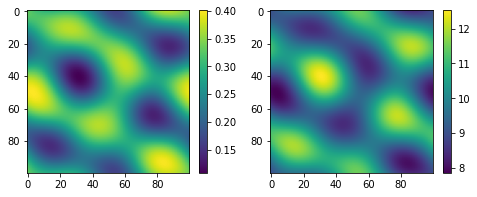

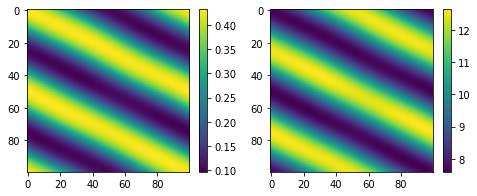

In [8]:
_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(data[0,:,:, 800])
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(data[1,:,:, 800])
plt.colorbar(shrink=.75)
plt.show()

_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(data[0,:,:, -1])
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(data[1,:,:, -1])
plt.colorbar(shrink=.75)
plt.show()

In [9]:
dxdy = x_size*y_size/L**2
c_xx =  np.array([[ dxdy  * second_order_derivatives((x_size,y_size), data[c, ..., t])[0] 
                    for t in range(data.shape[3])]
                    for c in range(data.shape[0])
                   ])
c_xx = np.einsum("ctij -> cijt", c_xx)
c_yy = np.array([[ dxdy * second_order_derivatives((x_size,y_size), data[c, ..., t])[1] 
                    for t in range(data.shape[3])]
                    for c in range(data.shape[0])
                   ])
c_yy = np.einsum("ctij -> cijt", c_yy)

c_t = np.array([[(data[c, ..., t+1] -  data[c, ..., t])/(t_star[t+1] - t_star[t])
                    for t in range(data.shape[3]-1)]
                    for c in range(data.shape[0])
                   ])
c_t = np.einsum("ctij -> cijt", c_t)

In [10]:
t_star[800::10].shape

(74,)

In [11]:
t_star = t_star[800::10]
data = data[..., 800::10]
T = t_star.shape[0]  

In [21]:
indices_all = np.arange(0, x_size*y_size*T, 1).reshape((T, x_size,y_size))
indices_sub = indices_all[:, 30:65, 50:85]
block_x = indices_sub.shape[1]
block_y = indices_sub.shape[2]
block_size = indices_sub.shape[1]*indices_sub.shape[2]


model_params = {'training_data_size': x_size*y_size*T,
                'pde_data_size': x_size*y_size*T,
                'boundary_data_size':((x_size + y_size)*T),
                'diffusion': None,
                'derivatives':[c_xx, c_yy, c_t], 
                'signal_to_noise':0.0,
                'shuffle':False,
                'idx_data':indices_sub.flatten()}

dataset = create_dataset(data, t_star, N, T, L, **model_params)
lb = dataset['lb']
ub = dataset['ub']


obs_inputs = dataset['obs_input']
obs_outputs = dataset['obs_output']
init_index = block_x*block_y
init_X = np.concatenate([obs_inputs[:init_index,:], obs_outputs[:init_index,:]], axis=1)
obs_X = obs_inputs
pde_X = obs_inputs
pbc_X = np.concatenate([dataset['boundary_LB'], dataset['boundary_RT']], axis=1)

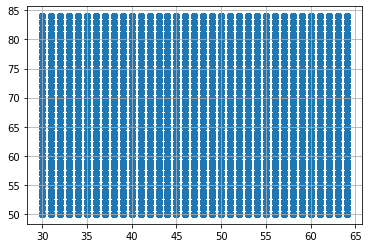

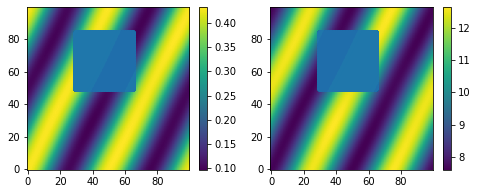

In [22]:
plt.scatter((x_size-1)*obs_X[:,0]/L, (x_size-1)*obs_X[:,1]/L)
plt.grid()
plt.show()

## Important Note:
##                Since in data the x is the first and y is the second indices,
##                x is cnahging in the outer arrays. So, we must transpose them on
##                ploting time
_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(data[0,:,:, -1].T, origin='lower')
plt.colorbar(shrink=.75)
plt.scatter((x_size-1)*obs_X[:,0]/L, (y_size-1)*obs_X[:,1]/L, alpha=.1)
plt.subplot(122)
plt.imshow(data[1,:,:, -1].T, origin='lower')
plt.colorbar(shrink=.75)
plt.scatter((x_size-1)*obs_X[:,0]/L, (y_size-1)*obs_X[:,1]/L, alpha=.1)
plt.show()

In [23]:
ds_obs = TINN_Dataset(tf.float32, init_X, pde_X, pbc_X)

In [24]:
ds_obs.sizes

array([ 1225, 90650, 14800])

In [25]:
layers = [3, 512, 512, 512, 512, 2]

pinnKM = tu.NN(layers, lb, ub, dtype=tf.float32)
pde_resKM = Koch_Meinhard(
                    #dtype = pinnKM.dtype,
                    D_u=PDE_Parameter("D_u", Parameter_Type.CONSTANT, simulation.Ds[0], dtype=pinnKM.dtype),
                    #D_u=PDE_Parameter("D_u", Parameter_Type.VARIABLE, 1.0, dtype=pinnKM.dtype),
                    D_v=PDE_Parameter("D_v", Parameter_Type.CONSTANT,  simulation.Ds[1], dtype=pinnKM.dtype),
                    #D_v=PDE_Parameter("D_v", Parameter_Type.VARIABLE,  1.0, dtype=pinnKM.dtype),
                    #kappa_u=PDE_Parameter("kappa_u", Parameter_Type.VARIABLE, 1.0,dtype=pinnKM.dtype, clip_constraint=None),
                    kappa_u=PDE_Parameter("kappa_u", Parameter_Type.CONSTANT, simulation.parameters["kappa_u"] ,dtype=pinnKM.dtype),
                    #mu_u=PDE_Parameter("mu_u", Parameter_Type.VARIABLE, 1.0,dtype=pinnKM.dtype, clip_constraint=None),
                    mu_u=PDE_Parameter("mu_u", Parameter_Type.CONSTANT, simulation.parameters["mu_u"],dtype=pinnKM.dtype),
                    #rho_u=PDE_Parameter("rho_u", Parameter_Type.VARIABLE, 1.0,dtype=pinnKM.dtype, clip_constraint=None),
                    rho_u=PDE_Parameter("rho_u", Parameter_Type.CONSTANT, simulation.parameters["rho_u"],dtype=pinnKM.dtype),                    
                    #rho_v=PDE_Parameter("rho_v", Parameter_Type.VARIABLE, 1.0,dtype=pinnKM.dtype, clip_constraint=None),                    
                    rho_v=PDE_Parameter("rho_v", Parameter_Type.CONSTANT, simulation.parameters["rho_v"],dtype=pinnKM.dtype),                    
                    #sigma_u=PDE_Parameter("sigma_u", Parameter_Type.VARIABLE, 1.0,dtype=pinnKM.dtype, clip_constraint=None),
                    sigma_u=PDE_Parameter("sigma_u", Parameter_Type.CONSTANT, simulation.parameters["sigma_u"],dtype=pinnKM.dtype),
                    #sigma_v=PDE_Parameter("sigma_v", Parameter_Type.VARIABLE, 1.0,dtype=pinnKM.dtype, clip_constraint=None),
                    sigma_v=PDE_Parameter("sigma_v", Parameter_Type.CONSTANT, simulation.parameters["sigma_v"],dtype=pinnKM.dtype),

    regularise=True,
    print_precision=".10f",
    )

pbc = Periodic_Boundary_Condition(print_precision=".10f")
pbc.residual_ret_names=("periodic boundary",)
init_condition_loss = Observation_Loss(layers=layers, 
                           residual_ret_names=("u", "v"),
                           )

modelKM = tu.TINN(pinnKM, 
                  losses= [init_condition_loss, pde_resKM, pbc],
                  norm = L2(),
                  optimizer=keras.optimizers.Adam(learning_rate=1e-4),
                  alpha = 0.9, 
                  loss_penalty_power = 3,
                  print_precision=".10f")

In [26]:
sizes = ds_obs.sizes
ds_obs = ds_obs.shuffle(np.max(sizes))
setattr(ds_obs,"sizes", sizes) 

In [ ]:
90650/10

In [27]:
results_KM = modelKM.train(epochs = 5000+1,
                          batch_size = 9065,
                          dataset = ds_obs,
                          print_interval=100,
                          stop_threshold = 9e-8,
                          sample_losses = True,              
                          sample_regularisations = True,
                          regularise=True,
                          regularise_interval=10)


Start of epoch 0


2023-01-19 09:39:34.295029: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2023-01-19 09:40:12.657633: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10


total loss: 886.9115176111, total regularised loss: 886.9114990234
Observation_Loss -> 
(1)  u: 0.0454216162 (2)  v: 87.5671057701 
Loss_Koch_Meinhard -> 
(3)  res u: 0.0000170824 (4)  res v: 0.9999932051 
Periodic_Boundary_Condition -> 
(5)  periodic boundary: 0.0786170729 
(1) lambdas : 1.0000000000 (2) lambdas : 1.0000000000 (3) lambdas : 1.0000000000 
(4) lambdas : 1.0000000000 (5) lambdas : 1.0000000000 
Time taken: 93.15s

Start of epoch 100
total loss: 4.8543500192, total regularised loss: 5.8255672455
Observation_Loss -> 
(1)  u: 0.0018608205 (2)  v: 0.2174862865 
Loss_Koch_Meinhard -> 
(3)  res u: 0.0003296376 (4)  res v: 0.0598302735 
Periodic_Boundary_Condition -> 
(5)  periodic boundary: 0.2059279904 
(1) lambdas : 0.3486804962 (2) lambdas : 1.6643500328 (3) lambdas : 0.3486786187 
(4) lambdas : 1.8817368746 (5) lambdas : 0.7565537691 
Time taken: 155.85s

Start of epoch 200
total loss: 0.8033623938, total regularised loss: 1.5910007954
Observation_Loss -> 
(1)  u: 0.001809


Start of epoch 1900
total loss: 0.0538677644, total regularised loss: 0.0530570410
Observation_Loss -> 
(1)  u: 0.0007500671 (2)  v: 0.0015175703 
Loss_Koch_Meinhard -> 
(3)  res u: 0.0005768111 (4)  res v: 0.0017667790 
Periodic_Boundary_Condition -> 
(5)  periodic boundary: 0.0007755491 
(1) lambdas : 1.3086340427 (2) lambdas : 0.9811541438 (3) lambdas : 0.9746889472 
(4) lambdas : 0.9061159492 (5) lambdas : 0.8294069171 
Time taken: 113.89s

Start of epoch 2000
total loss: 0.0353506151, total regularised loss: 0.0351789817
Observation_Loss -> 
(1)  u: 0.0006754236 (2)  v: 0.0008012661 
Loss_Koch_Meinhard -> 
(3)  res u: 0.0005285483 (4)  res v: 0.0009524457 
Periodic_Boundary_Condition -> 
(5)  periodic boundary: 0.0005773778 
(1) lambdas : 1.2199048996 (2) lambdas : 1.1098507643 (3) lambdas : 1.2079143524 
(4) lambdas : 0.9043146372 (5) lambdas : 0.5580152273 
Time taken: 113.74s

Start of epoch 2100
total loss: 0.0400883554, total regularised loss: 0.0409850143
Observation_Loss -


Start of epoch 3800
total loss: 0.0211213474, total regularised loss: 0.0274321605
Observation_Loss -> 
(1)  u: 0.0003998423 (2)  v: 0.0004465210 
Loss_Koch_Meinhard -> 
(3)  res u: 0.0000097867 (4)  res v: 0.0011117536 
Periodic_Boundary_Condition -> 
(5)  periodic boundary: 0.0001442312 
(1) lambdas : 2.5096924305 (2) lambdas : 0.9933872223 (3) lambdas : 0.0019642094 
(4) lambdas : 1.1971120834 (5) lambdas : 0.2978441119 
Time taken: 113.92s

Start of epoch 3900
total loss: 0.0147620699, total regularised loss: 0.0201192964
Observation_Loss -> 
(1)  u: 0.0004529372 (2)  v: 0.0003661764 
Loss_Koch_Meinhard -> 
(3)  res u: 0.0000121771 (4)  res v: 0.0004427061 
Periodic_Boundary_Condition -> 
(5)  periodic boundary: 0.0002022103 
(1) lambdas : 2.1793961525 (2) lambdas : 1.2554087639 (3) lambdas : 0.0019987973 
(4) lambdas : 1.0551123619 (5) lambdas : 0.5080836415 
Time taken: 113.83s

Start of epoch 4000
total loss: 0.0143250618, total regularised loss: 0.0197991058
Observation_Loss -

In [ ]:
modelKM.optimizer.lr.assign(5e-5)
results_KM2 = modelKM.train(epochs = 5000+1,
                          batch_size = 245,
                          dataset = ds_obs,
                          print_interval=100,
                          stop_threshold = 9e-8,
                          sample_losses = True,              
                          sample_regularisations = True,
                          regularise=True,
                          regularise_interval=10)


Start of epoch 0
total loss: 0.4854315227, total regularised loss: 0.6651164889
Observation_Loss -> 
(1)  u: 0.0003372935 (2)  v: 0.0002719780 
Loss_Koch_Meinhard -> 
(3)  res u: 0.0000221845 (4)  res v: 0.0005615984 
Periodic_Boundary_Condition -> 
(5)  periodic boundary: 0.0001189228 
(1) lambdas : 2.5109055042 (2) lambdas : 0.8557621241 (3) lambdas : 0.0248469282 
(4) lambdas : 1.1884878874 (5) lambdas : 0.4199979305 
Time taken: 32.03s

Start of epoch 100
total loss: 0.4883401154, total regularised loss: 0.6376345158
Observation_Loss -> 
(1)  u: 0.0002676158 (2)  v: 0.0003019480 
Loss_Koch_Meinhard -> 
(3)  res u: 0.0000277653 (4)  res v: 0.0005393821 
Periodic_Boundary_Condition -> 
(5)  periodic boundary: 0.0001831270 
(1) lambdas : 2.4959115982 (2) lambdas : 0.7249325514 (3) lambdas : 0.0511350706 
(4) lambdas : 1.4699977636 (5) lambdas : 0.2580229640 
Time taken: 552.76s

Start of epoch 200
total loss: 0.4234742676, total regularised loss: 0.5370295644
Observation_Loss -> 
(1)


Start of epoch 1900
total loss: 0.0675628606, total regularised loss: 0.0753670931
Observation_Loss -> 
(1)  u: 0.0000176372 (2)  v: 0.0000729523 
Loss_Koch_Meinhard -> 
(3)  res u: 0.0000072304 (4)  res v: 0.0000552470 
Periodic_Boundary_Condition -> 
(5)  periodic boundary: 0.0000295354 
(1) lambdas : 0.8614377975 (2) lambdas : 1.2510712147 (3) lambdas : 0.6624306440 
(4) lambdas : 1.0619107485 (5) lambdas : 1.1631493568 
Time taken: 523.02s

Start of epoch 2000
total loss: 0.0681263485, total regularised loss: 0.0808487013
Observation_Loss -> 
(1)  u: 0.0000178673 (2)  v: 0.0000708778 
Loss_Koch_Meinhard -> 
(3)  res u: 0.0000067343 (4)  res v: 0.0000617005 
Periodic_Boundary_Condition -> 
(5)  periodic boundary: 0.0000269454 
(1) lambdas : 0.9540549517 (2) lambdas : 1.5293254852 (3) lambdas : 0.4902407229 
(4) lambdas : 1.0296043158 (5) lambdas : 0.9967746139 
Time taken: 531.45s

Start of epoch 2100
total loss: 0.0626175469, total regularised loss: 0.0735482126
Observation_Loss -

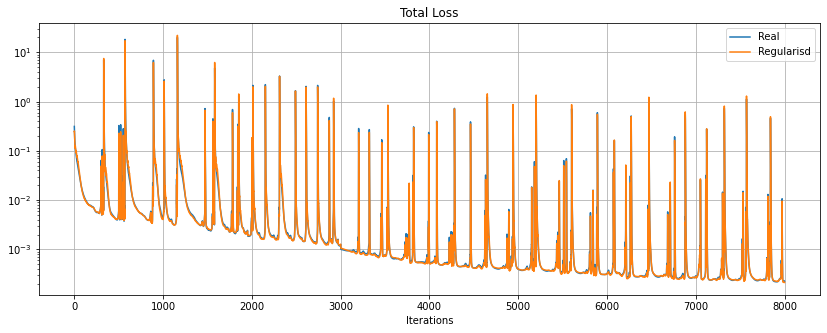

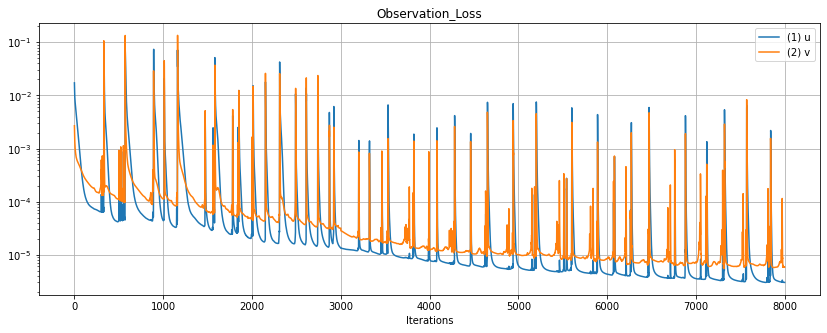

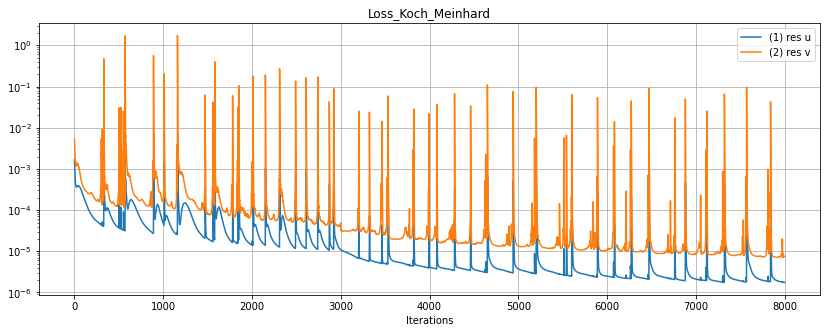

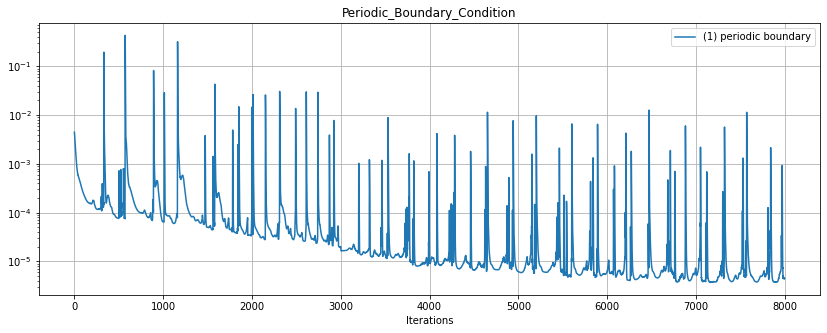

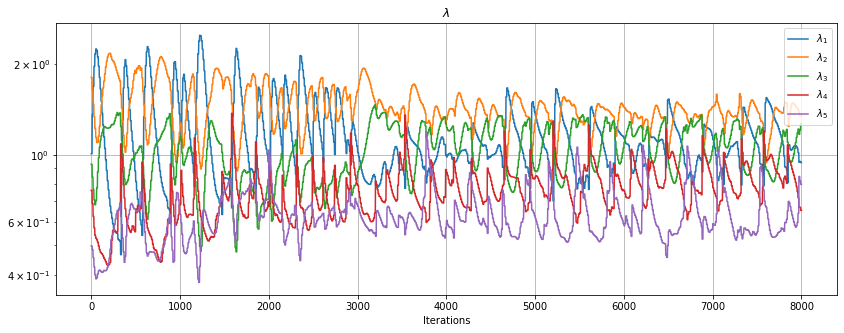

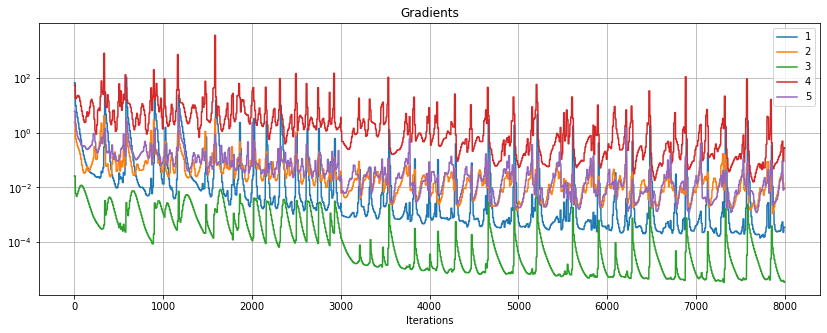

In [81]:
plot_result(merge_dict(results_KM,results_KM2,), modelKM, start=2000)

In [73]:
test_d = obs_X[:,:3].astype(np.float32)

In [82]:
r = pde_resKM.residual(pinnKM, test_d)
l2 = L2()

print([np.mean(i.numpy()**2) for i in r ])
print(l2.reduce_norm(r).numpy())
print(np.sqrt(l2.reduce_norm(r).numpy()))

[1.7497978e-06, 7.041384e-06]
[1.7497978e-06 7.0413839e-06]
[0.0013228  0.00265356]


In [75]:
@tf.function
def derivatives(pinn, x):
    return pde_resKM.derivatives(pinn, x)

In [83]:
(y, u, u_t, u_xx, u_yy, v, v_t, v_xx, v_yy) =  derivatives(pinnKM,test_d)


u1 = u.numpy()[:block_size].reshape(block_x, block_y).T
u2 = u.numpy()[block_size:].reshape(block_x, block_y).T

v1 = v.numpy()[:block_size].reshape(block_x, block_y).T
v2 = v.numpy()[block_size:].reshape(block_x, block_y).T

u_xx1 = u_xx.numpy()[:block_size].reshape(block_x, block_y).T
u_xx2 = u_xx.numpy()[block_size:].reshape(block_x, block_y).T

v_xx1 = v_xx.numpy()[:block_size].reshape(block_x, block_y).T
v_xx2 = v_xx.numpy()[block_size:].reshape(block_x, block_y).T


u_yy1 = u_yy.numpy()[:block_size].reshape(block_x, block_y).T
u_yy2 = u_yy.numpy()[block_size:].reshape(block_x, block_y).T

v_yy1 = v_yy.numpy()[:block_size].reshape(block_x, block_y).T
v_yy2 = v_yy.numpy()[block_size:].reshape(block_x, block_y).T

u_t1 = u_t.numpy()[:block_size].reshape(block_x, block_y).T
u_t2 = u_t.numpy()[block_size:].reshape(block_x, block_y).T

v_t1 = v_t.numpy()[:block_size].reshape(block_x, block_y).T
v_t2 = v_t.numpy()[block_size:].reshape(block_x, block_y).T

In [77]:
der_u_outputs = dataset["der_u"].T
der_v_outputs = dataset["der_v"].T

In [84]:
print(np.sqrt(np.mean((u_xx1-der_u_outputs[:block_size,0].reshape(block_x, block_y).T)**2)))
print(np.sqrt(np.mean((u_yy1-der_u_outputs[:block_size,1].reshape(block_x, block_y).T)**2)))
print(np.sqrt(np.mean((u_t1-der_u_outputs[:block_size,2].reshape(block_x, block_y).T)**2)))
print(np.sqrt(np.mean((v_xx1-der_v_outputs[:block_size,0].reshape(block_x, block_y).T)**2)))
print(np.sqrt(np.mean((v_yy1-der_v_outputs[:block_size,1].reshape(block_x, block_y).T)**2)))
print(np.sqrt(np.mean((v_t1-der_v_outputs[:block_size,2].reshape(block_x, block_y).T)**2)))

0.017223205478631706
0.0173736134890851
0.003657964056587587
0.2760490043090646
0.27877746879917464
0.44962832672193775


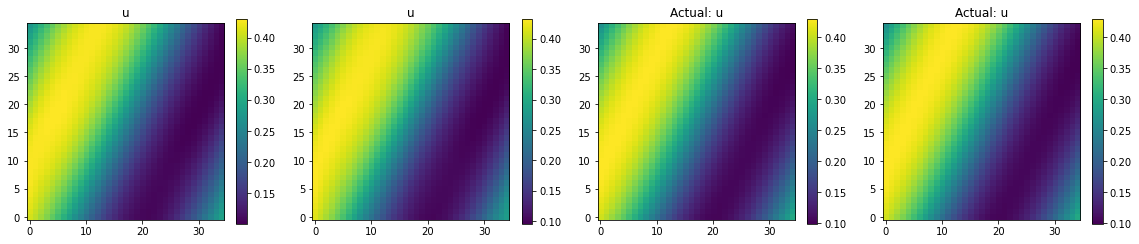

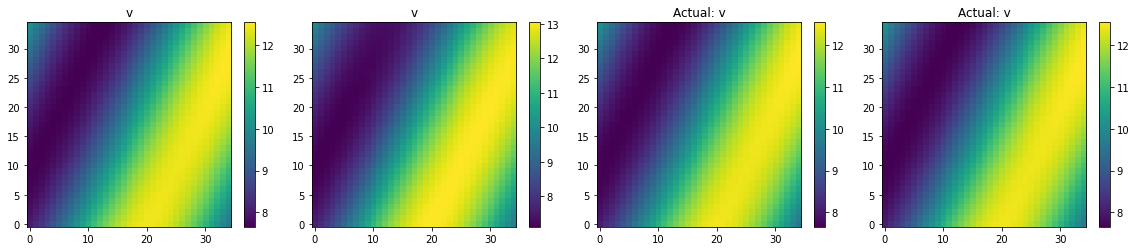

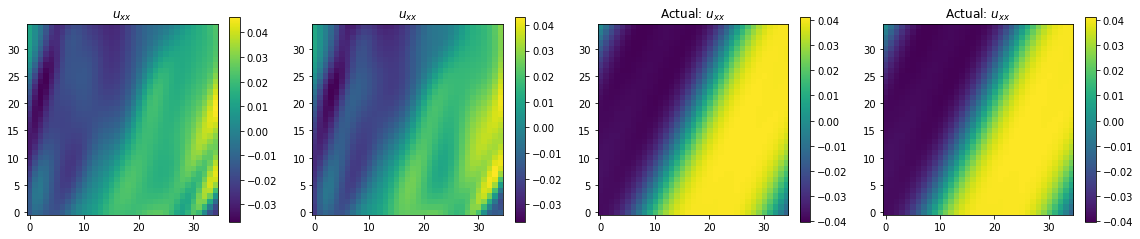

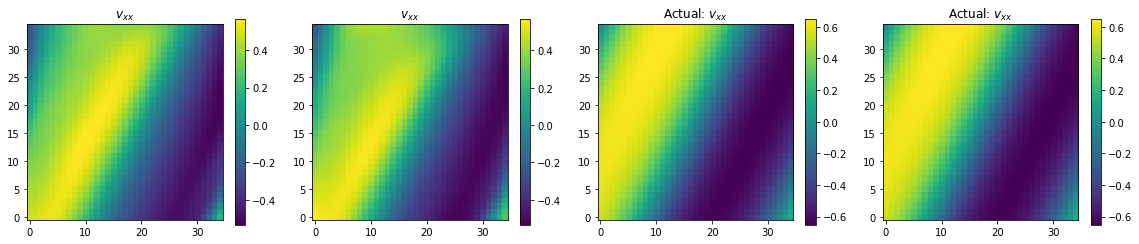

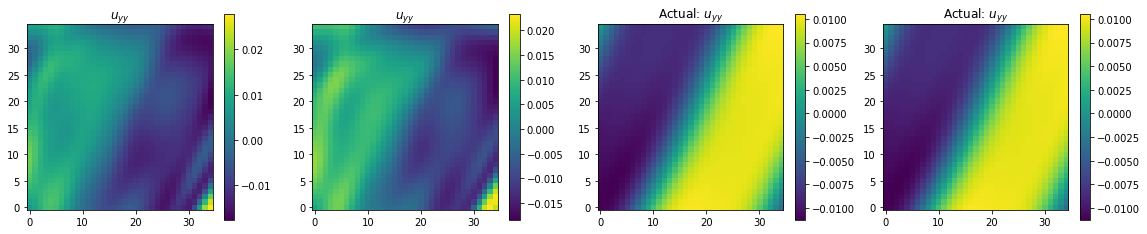

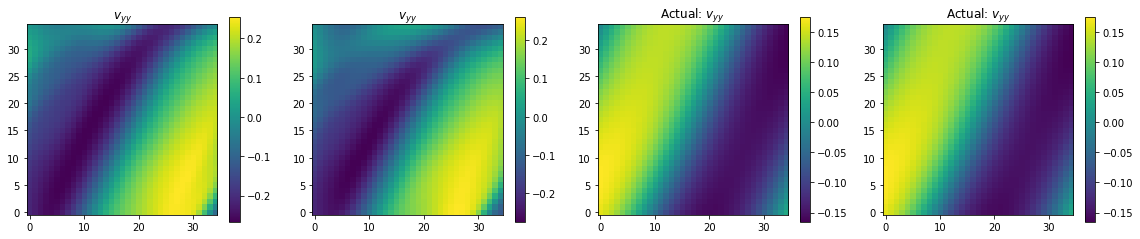

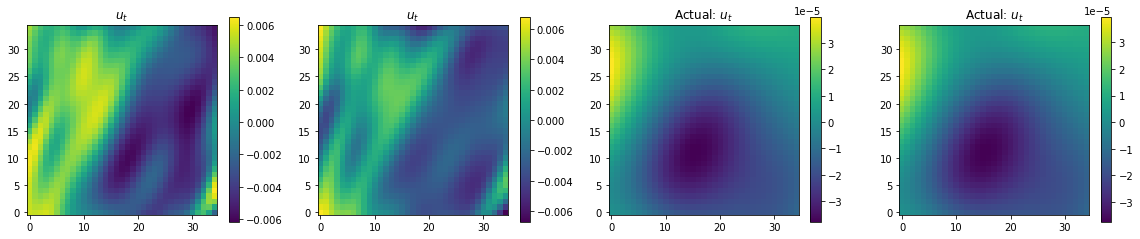

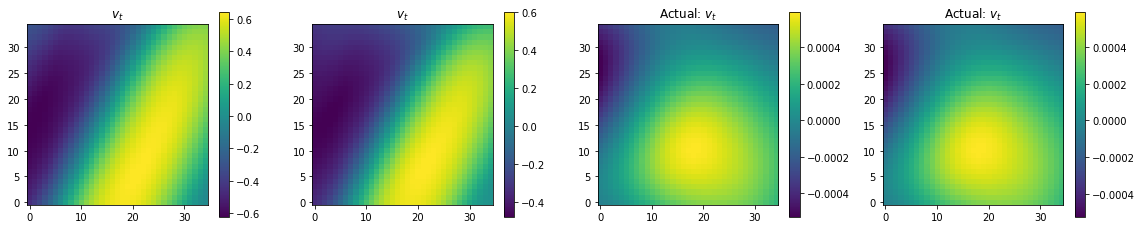

In [85]:
def p(m1, m2,  m3, m4, title=""):
    _ = plt.figure(figsize=(16,6))    
    plt.subplot(141)
    plt.title(title)
    plt.imshow(m1,
               origin='lower')
    plt.colorbar(shrink=.5)
    plt.subplot(142)
    plt.title(title)
    plt.imshow(m2,
               origin='lower')
    plt.colorbar(shrink=.5)

    plt.subplot(143)
    plt.title("Actual: " + title)
    plt.imshow(m3.reshape(block_x, block_y).T,
               origin='lower')
    plt.colorbar(shrink=.5)
    plt.subplot(144)
    plt.title("Actual: " + title)
    plt.imshow(m4.reshape(block_x, block_y).T,
               origin='lower')
    plt.colorbar(shrink=.5)
    plt.tight_layout()
    plt.show()
p(u1, u2, obs_outputs[:block_size,0], obs_outputs[block_size:,0], "u")
p(v1, v2, obs_outputs[:block_size,1], obs_outputs[block_size:,1], "v")
p(u_xx1, u_xx2, der_u_outputs[:block_size,0], der_u_outputs[block_size:,0], r"$u_{xx}$")
p(v_xx1, v_xx2, der_v_outputs[:block_size,0], der_v_outputs[block_size:,0], r"$v_{xx}$")
p(u_yy1, u_yy2, der_u_outputs[:block_size,1], der_u_outputs[block_size:,1], r"$u_{yy}$")
p(v_yy1, v_yy2, der_v_outputs[:block_size,1], der_v_outputs[block_size:,1], r"$v_{yy}$")
p(u_t1, u_t2, der_u_outputs[:block_size,2], der_u_outputs[block_size:,2], r"$u_{t}$")
p(v_t1, v_t2, der_v_outputs[:block_size,2], der_v_outputs[block_size:,2], r"$v_{t}$")

